In [70]:
import numpy as np
import matplotlib.pyplot as plt
# from getdist.mcsamples import loadMCSamples
from getdist.mcsamples import MCSamples
from getdist import plots
from classy_sz import Class as Class_sz
!export JAX_PLATFORMS=cpu

/usr/lib64/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [71]:
%%time
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'jax': 1,
})
classy_sz.compute_class_szfast()

CPU times: user 5.22 ms, sys: 337 µs, total: 5.56 ms
Wall time: 4.81 ms


In [72]:
# Define chain directory
# chain_dir = r'/Users/licongxu/Work/tszpower/chains/tszpower_chain'
# chain_dir = r'/Users/licongxu/Desktop/chains/tszpower_chain'
samples_dir = r"/data/vault/lx256/tsz_project/tszpower/samples_nle/samples_NLE1t1000.txt"
# samples_dir = r"/data/vault/lx256/tsz_project/tszpower/samples_npe/samples_NPE_3000.txt"
# samples_dir = r"/data/vault/lx256/tsz_project/tszpower/samples_nre/samples_NRE_3000.txt"
data = np.loadtxt(samples_dir, skiprows=0)
# Define the parameter names and (optional) pretty labels:
names = ['logA', 'omega_b', 'omega_cdm', 'H0', 'n_s', 'B', 'A_cib', 'A_rs', 'A_ir']
labels = [r'\logA', r'\omega_b', r'\omega_{cdm}', r'H_0', r'n_s', r'B', r'A_{\rm cib}', r'A_{\rm rs}', r'A_{\rm ir}']

# Load MCMC samples
# ignore_row = 0.5
readsamps = MCSamples(samples = data, names=names, labels=labels)
print(readsamps.samples)
print(readsamps.getParamNames())

Removed no burn in
[[3.4903996  0.02482046 0.11683448 ... 0.28766504 0.63083482 1.51568365]
 [3.45420671 0.0218551  0.11531353 ... 0.32767373 0.38199469 1.61611688]
 [3.4131     0.02318958 0.11948467 ... 0.26145735 0.26472169 1.82702649]
 ...
 [2.95504594 0.02252249 0.1188819  ... 0.4669902  0.11495367 1.96231866]
 [2.9441328  0.0208297  0.1169731  ... 0.49006745 0.18126056 2.15145755]
 [2.95900512 0.02482995 0.11487164 ... 0.48612779 0.03798692 2.04494166]]
logA	\logA
omega_b	\omega_b
omega_cdm	\omega_{cdm}
H0	H_0
n_s	n_s
B	B
A_cib	A_{\rm cib}
A_rs	A_{\rm rs}
A_ir	A_{\rm ir}



In [73]:
p = readsamps.getParams()
print('Adding derived parameters')

# Compute sigma8 for each sample
sigma8_values = []

for i in range(len(p.logA)):
    logA = p.logA[i]
    omega_cdm = p.omega_cdm[i]
    omega_b = p.omega_b[i]
    H0 = p.H0[i]
    n_s = p.n_s[i]
    cosmo_params = {
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'H0': H0,
        'ln10^{10}A_s': logA,
        'n_s': n_s,
    }

    A_s_dict = cosmo_params
    sigma8 = classy_sz.get_sigma8_and_der(params_values_dict=A_s_dict)[1]  # Compute sigma8
    sigma8_values.append(sigma8)


# Convert list to numpy array
sigma8_values = np.array(sigma8_values)

# Add derived parameters to MCMC samples
readsamps.addDerived(sigma8_values, name='sigma8', label=r'\sigma_8')
# Compute derived parameter: ln(1/A_rs)
ln_1_A_rs = np.log(1.0 / p.A_rs)

# Add derived parameter to samples
readsamps.addDerived(ln_1_A_rs, name='ln_1_A_rs', label=r'\ln(1/A_\mathrm{rs})')
print("Derived parameters added successfully.")

Adding derived parameters
Derived parameters added successfully.


In [74]:
p.logA

array([3.4903996 , 3.45420671, 3.4131    , ..., 2.95504594, 2.9441328 ,
       2.95900512])

In [75]:
# Compute h and Omega_m for each sample
h = p.H0 / 100.0  # Compute h
Omega_m = (p.omega_cdm + p.omega_b) / h**2  # Compute Omega_m

# Compute F = sigma8 * (Omega_m / B)^0.40 * h^-0.21
F_values = sigma8_values * (Omega_m / p.B) ** (0.40) * h ** (-0.21)

# Add F as a derived parameter
readsamps.addDerived(F_values, name='F', label=r'F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21}')

# **Force GetDist to recognize the new parameter**
readsamps.updateBaseStatistics()

print("Derived parameter F added successfully.")


Derived parameter F added successfully.


In [76]:
Fs = readsamps.getInlineLatex('F',limit=1)
A_cib = readsamps.getInlineLatex('A_cib',limit=1)
print('F: ',Fs)
print('A_cib: ',A_cib)

F:  F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21} = 0.4815^{+0.0043}_{-0.0058}
A_cib:  A_{\rm cib} = 0.39^{+0.15}_{-0.11}


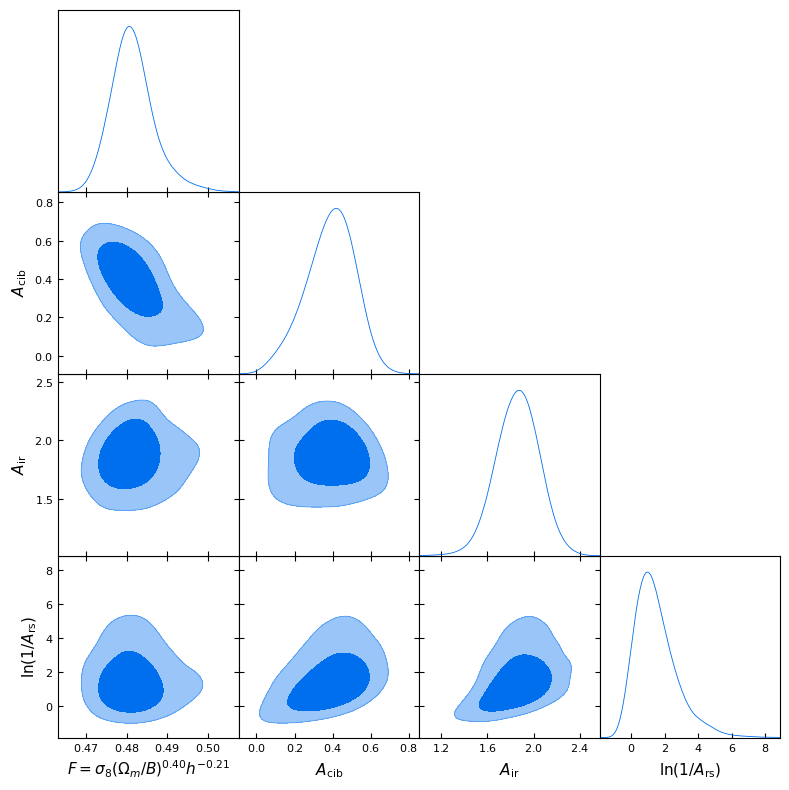

In [77]:
%matplotlib inline
# Define parameters to plot
params_to_plot = ['F', 'A_cib', 'A_ir','ln_1_A_rs']

# Create a triangle plot (corner plot)
g = plots.get_subplot_plotter()
g.triangle_plot(readsamps, params_to_plot, filled=True)

# Adjust axis limits for specific parameters
# g.subplots[0, 0].set_xlim(0.42, 0.52)  # Adjust x-axis limit for 'F'
# g.subplots[1, 1].set_xlim(0, 1)  # Adjust x-axis limit for 'A_cib'
# g.subplots[2, 2].set_xlim(1.5, 2.5)  # Adjust x-axis limit for 'A_ir'
# g.subplots[3, 3].set_xlim(-1.5, 6) # Adjust x-axis limit for 'ln_1_A_rs'

# Show the plot
plt.show()